## __Importing required frameworks__

In [ ]:
# custom lib
HAS_GPU = 0

if HAS_GPU:
    !pip install mxnet-cu80
else:
    !pip install mxnet

In [1]:
import mxnet as mx
from mxnet import nd, autograd, gluon
from mxnet.gluon import nn
from mxnet.gluon.data import vision
from matplotlib import pyplot as plt

import os
from scipy.special import digamma

ctx = mx.cpu()

## __Doing data augmentation and defining data loaders__

In [2]:
train_transform = vision.transforms.Compose([vision.transforms.RandomSaturation(saturation = 0.2),
                                             vision.transforms.RandomLighting(alpha = 0.2),
                                             vision.transforms.RandomHue(hue = 0.1),
                                             vision.transforms.RandomFlipLeftRight(),
                                             vision.transforms.RandomContrast(contrast = 0.2),
                                             vision.transforms.RandomColorJitter(brightness = 0.1, contrast = 0.1, saturation = 0.1, hue = 0.1),                                            
                                             vision.transforms.ToTensor()])

transform = vision.transforms.Compose([vision.transforms.ToTensor()])

train_cifar = gluon.data.vision.CIFAR10(train = True).transform_first(train_transform)
test_cifar = gluon.data.vision.CIFAR10(train = False).transform_first(transform)

In [3]:
batch_size = 64
train_data = gluon.data.DataLoader(train_cifar, batch_size = batch_size, shuffle = True)
test_data = gluon.data.DataLoader(test_cifar, batch_size = batch_size, shuffle = False)

In [4]:
for features, labels in train_data:
    break

print(f"features.shape: {features.shape}")
print(f"labels.shape: {labels.shape}")

print(f"features.max(): {features.max().asscalar()}")
print(f"features.min(): {features.min().asscalar()}")

features.shape: (64, 3, 32, 32)
labels.shape: (64,)
features.max(): 1.0
features.min(): 0.0


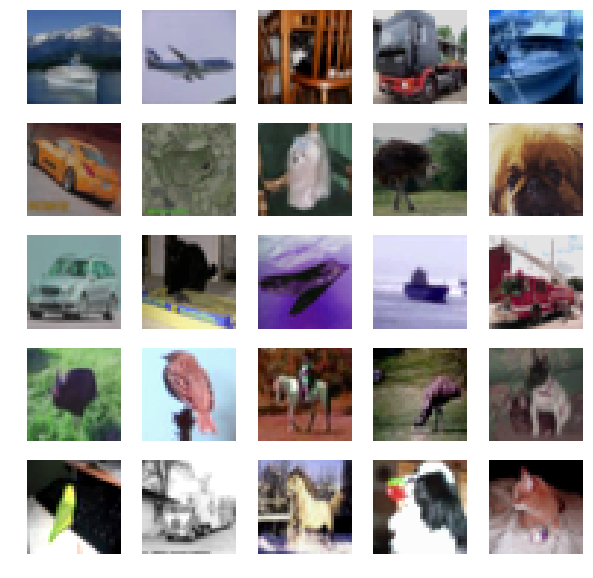

50000


In [5]:
plt.figure(figsize = (10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(features[i].transpose((1, 2, 0)).asnumpy())
    plt.axis("off")
plt.show()
print(len(train_cifar))

## __Defining model architecture__

In [ ]:
model = nn.HybridSequential()

model.add(nn.Conv2D(32, (3, 3), padding = (1, 1)))
model.add(nn.LeakyReLU(0.2))
model.add(nn.BatchNorm())
model.add(nn.Conv2D(32, (3, 3), padding = (1, 1)))
model.add(nn.LeakyReLU(0.2))
model.add(nn.BatchNorm())
model.add(nn.MaxPool2D(pool_size=(2,2)))
model.add(nn.Dropout(0.2))

model.add(nn.Conv2D(64, (3, 3), padding = (1, 1)))
model.add(nn.LeakyReLU(0.2))
model.add(nn.BatchNorm())
model.add(nn.Conv2D(64, (3, 3), padding = (1, 1)))
model.add(nn.LeakyReLU(0.2))
model.add(nn.BatchNorm())
model.add(nn.MaxPool2D(pool_size=(2,2)))
model.add(nn.Dropout(0.3))

model.add(nn.Conv2D(128, (3, 3), padding = (1, 1)))
model.add(nn.LeakyReLU(0.2))
model.add(nn.BatchNorm())
model.add(nn.Conv2D(128, (3, 3), padding = (1, 1)))
model.add(nn.LeakyReLU(0.2))
model.add(nn.BatchNorm())
model.add(nn.MaxPool2D(pool_size=(2,2)))
model.add(nn.Dropout(0.4))

model.add(nn.Flatten())
model.add(nn.Dense(10))

model.initialize(mx.init.Xavier(), ctx)
model.load_parameters("cifar10_deterministic_acc71.params", ctx=ctx)

## __Summarizing model layers__

In [ ]:
model.summary(features.as_in_context(ctx))

## __Hybridizing and defining objective loss and optimizer__

In [ ]:
# model.hybridize()
objective = gluon.loss.SoftmaxCrossEntropyLoss()
optimizer = mx.optimizer.Adam(learning_rate = 0.0005)
trainer = gluon.Trainer(model.collect_params(), optimizer)
top1 = mx.metric.Accuracy()
top3 = mx.metric.TopKAccuracy(top_k = 3)

## __Training the model__

In [ ]:
epochs = 1
batches = len(train_data)

train_losses = []
top1_accs = []
top3_accs = []

for epoch in range(epochs):
    top1.reset()
    top3.reset()
    cum_loss = 0.0
    for features, labels in train_data:
        features = features.as_in_context(ctx)
        labels = labels.as_in_context(ctx)

        with autograd.record():
            outputs = model(features)
            loss = objective(outputs, labels)
        loss.backward()
        trainer.step(batch_size)

        cum_loss += loss.mean()
        top1.update(labels, outputs)
        top3.update(labels, outputs)

    train_loss = cum_loss.asscalar()/batches
    top1_acc = top1.get()[1]
    top3_acc = top3.get()[1]

    train_losses.append(train_loss)
    top1_accs.append(top1_acc)
    top3_accs.append(top3_acc)
    
    print(f'Epoch: {epoch + 1} | Training Loss: {train_loss:.5f} | Top 1 Accuracy: {top1_acc:.5f} | Top 3 Accuracy: {top3_acc:.5f}')

# Evidential Deep Learning Framework

In [6]:
model_edl = nn.HybridSequential()

model_edl.add(nn.Conv2D(32, (3, 3), padding = (1, 1)))
model_edl.add(nn.LeakyReLU(0.2))
model_edl.add(nn.BatchNorm())
model_edl.add(nn.Conv2D(32, (3, 3), padding = (1, 1)))
model_edl.add(nn.LeakyReLU(0.2))
model_edl.add(nn.BatchNorm())
model_edl.add(nn.MaxPool2D(pool_size=(2,2)))
model_edl.add(nn.Dropout(0.2))

model_edl.add(nn.Conv2D(64, (3, 3), padding = (1, 1)))
model_edl.add(nn.LeakyReLU(0.2))
model_edl.add(nn.BatchNorm())
model_edl.add(nn.Conv2D(64, (3, 3), padding = (1, 1)))
model_edl.add(nn.LeakyReLU(0.2))
model_edl.add(nn.BatchNorm())
model_edl.add(nn.MaxPool2D(pool_size=(2,2)))
model_edl.add(nn.Dropout(0.3))

model_edl.add(nn.Conv2D(128, (3, 3), padding = (1, 1)))
model_edl.add(nn.LeakyReLU(0.2))
model_edl.add(nn.BatchNorm())
model_edl.add(nn.Conv2D(128, (3, 3), padding = (1, 1)))
model_edl.add(nn.LeakyReLU(0.2))
model_edl.add(nn.BatchNorm())
model_edl.add(nn.MaxPool2D(pool_size=(2,2)))
model_edl.add(nn.Dropout(0.4))

model_edl.add(nn.Flatten())
model_edl.add(nn.Dense(10, activation='relu'))

model_edl.initialize(force_reinit=True, init=mx.init.Xavier(), ctx=ctx)
model_edl.load_parameters("cifar10_stochastic_acc77.params", ctx=ctx)
model_edl.summary(features.as_in_context(ctx))
model_edl.hybridize(active=False)

--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                             (64, 3, 32, 32)               0
            Conv2D-1                            (64, 32, 32, 32)             896
         LeakyReLU-2                            (64, 32, 32, 32)               0
         BatchNorm-3                            (64, 32, 32, 32)             128
            Conv2D-4                            (64, 32, 32, 32)            9248
         LeakyReLU-5                            (64, 32, 32, 32)               0
         BatchNorm-6                            (64, 32, 32, 32)             128
         MaxPool2D-7                            (64, 32, 16, 16)               0
           Dropout-8                            (64, 32, 16, 16)               0
            Conv2D-9                            (64, 64, 16, 16)           18496
        LeakyReLU-10        

In [20]:
# custom loss
# reference: https://arxiv.org/pdf/1806.01768.pdf
class QuantityUncertaintyLoss(gluon.loss.Loss):
    def __init__(self, out_units=1, sparse_label=True, weight=None,
                 batch_axis=0, **kwargs):
        super(QuantityUncertaintyLoss, self).__init__(weight, 
                                                      batch_axis,
                                                      **kwargs)
        self.out_units_    = out_units
        self.sparse_label_ = sparse_label

    def mse_loss(self, F, label, alphas):
        S = F.sum(alphas, axis=1, keepdims=True)       
        S_brdcst = F.broadcast_like(S, alphas)
        
        p = alphas/(S_brdcst + 1e-5)
        likelihood_err = (label - p)**2
        likelihood_var = p*(1-p)/(S_brdcst + 1)

        return F.sum( likelihood_err + likelihood_var, axis=-1, keepdims=True)

    def kl_loss(self, F, label, alphas):
        kl_alphas = 1 + (1 - label)*alphas
        
        sum_alphas = F.sum(kl_alphas, axis=-1, keepdims=True)        
        ones = nd.ones(shape=alphas.shape, ctx=alphas.context)

        first_term = F.gammaln(sum_alphas) - F.gammaln(ones.sum(axis=1, keepdims=True)) - F.sum( F.gammaln(kl_alphas), axis=-1, keepdims=True)
        
        a = F.array(digamma(kl_alphas.asnumpy()))
        b = F.array(digamma(sum_alphas.asnumpy()))

        second_term = F.sum(  (kl_alphas - 1.0) * (a - F.broadcast_like(b, a) ),
                            axis=-1, keepdims=True)

        return first_term + second_term

    def hybrid_forward(self, F, label, evidence, t): 
        if self.sparse_label_:
            label = F.one_hot(label, self.out_units_)

        annealing_coeff = t/10.0
        if (annealing_coeff > 1.0):
            annealing_coeff = 1.0
        
        alphas = evidence + 1.0

        loss = self.mse_loss(F, label, alphas) + annealing_coeff*self.kl_loss(F, label, alphas)
        return F.sum(loss, axis=0, keepdims=True)

# helper functions to convert dirichlet parameters into probabilities, variances
def evidence_prob(evidence):
    alphas = evidence + 1.0
    sum_alphas = nd.sum(alphas, axis=-1, keepdims=True)
    sum_alphas_brdcst = nd.broadcast_like(sum_alphas, alphas)
    
    return alphas/(sum_alphas_brdcst + 1e-5)

def evidence_var(evidence, n_classes):
    alphas = evidence + 1.0
    sum_alphas = nd.sum(alphas, axis=-1, keepdims=True)
    sum_alphas_brdcst = nd.broadcast_like(sum_alphas, alphas)

    p = alphas/(sum_alphas_brdcst + 1e-5)       # dirichlet expectation
    var = p*(1-p)/(sum_alphas_brdcst + 1.0)     # dirichlet variance 
    total_var = n_classes/sum_alphas            # subjective logic variance

    return var, total_var

def evidence_prob_with_var(evidence, n_classes):
    alphas = evidence + 1.0
    sum_alphas = nd.sum(alphas, axis=-1, keepdims=True)
    sum_alphas_brdcst = nd.broadcast_like(sum_alphas, alphas)

    p = alphas/(sum_alphas_brdcst + 1e-5)      # dirichlet expectation
    var = p*(1-p)/(sum_alphas_brdcst + 1.0)    # dirichlet variance 
    total_var = n_classes/sum_alphas           # subjective logic variance

    return p, var, total_var

# training setup
objective = QuantityUncertaintyLoss(out_units=10)
optimizer = mx.optimizer.Adam(learning_rate = 1e-2)
trainer = gluon.Trainer(model_edl.collect_params(), optimizer)
top1 = mx.metric.Accuracy()
top3 = mx.metric.TopKAccuracy(top_k = 3)

In [21]:
# train
train_losses = []
top1_accs = []
top3_accs = []

for epoch in range(2):
    top1.reset()
    top3.reset()
    cum_loss = 0.0
    for i, (features, labels) in enumerate(train_data):
        features = features.as_in_context(ctx)
        labels = labels.as_in_context(ctx)

        with autograd.record():
            evidence = model_edl(features)
            loss = objective(labels, evidence, epoch+1.0)
        loss.backward()
        trainer.step(batch_size)

        cum_loss += loss.mean()
        output_prob = evidence_prob(evidence)
        top1.update(labels, output_prob)
        top3.update(labels, output_prob)
        
        print(f"{i}/{len(train_data)}", end='\r')
    print('\r')
    train_loss = cum_loss.asscalar()/len(train_data)
    top1_acc = top1.get()[1]
    top3_acc = top3.get()[1]

    train_losses.append(train_loss)
    top1_accs.append(top1_acc)
    top3_accs.append(top3_acc)

    print(f'Epoch: {epoch + 1} | Training Loss: {train_loss:.5f} | Top 1 Accuracy: {top1_acc:.5f} | Top 3 Accuracy: {top3_acc:.5f}')

781/782
Epoch: 1 | Training Loss: 124.69317 | Top 1 Accuracy: 0.55950 | Top 3 Accuracy: 0.82400


KeyboardInterrupt: 

# Compare Deterministic vs Stochastic Classification Techniques

In [ ]:
# verify accuracies from both networks

# Deterministic
top1.reset()
top3.reset()
for features, labels in test_data:
    features = features.as_in_context(ctx)
    labels = labels.as_in_context(ctx)
    outputs = model(features)
    top1.update(labels, outputs)
    top3.update(labels, outputs)
print(f'Deterministic Top-1 Accuracy: {top1.get()[1]}')
print(f'Deterministic Top-3 Accuracy: {top3.get()[1]}')

# Stochastic
top1.reset()
top3.reset()
for features, labels in test_data:
    features = features.as_in_context(ctx)
    labels = labels.as_in_context(ctx)
    outputs = model_edl(features)

    output_prob = dirichlet_strength_2_prob(outputs)
    top1.update(labels, output_prob)
    top3.update(labels, output_prob)
print(f'Stochastic Top-1 Accuracy: {top1.get()[1]}')
print(f'Stochastic Top-3 Accuracy: {top3.get()[1]}')

In [8]:
import numpy as np
np.set_printoptions(precision=3)

# helper functions 
def eval_deterministic(in_model, in_data):
    output = nd.SoftmaxActivation(in_model(in_data))
    return output

def eval_stochastic(in_model, in_data):
    evidence = in_model(in_data)
    prob, var, total_var = evidence_prob_with_var(evidence, 10)
    return prob, var, total_var

def add_noise(in_data, mean, std):
    noise = nd.abs(nd.random.normal(mean, std, in_data.shape))
    noise_data = in_data + noise
    
    return noise_data/nd.max(noise_data)

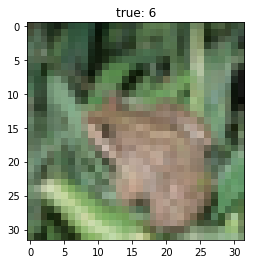

Deterministic: 


NameError: name 'model' is not defined

In [9]:
BATCH_IDX = 0
IMAGE_IDX = 4

data       =  next(iter(test_data))
input_data = (data[0][IMAGE_IDX]).asnumpy()
input_data = input_data.transpose((1, 2, 0))
true_output = data[1][IMAGE_IDX].asscalar()

# true image
plt.figure()
plt.imshow(input_data)
plt.title(f"true: {true_output}")
plt.show()

print("Deterministic: ")
p = eval_deterministic(model, nd.expand_dims(data[0][IMAGE_IDX], axis=0)).asnumpy()
best_class = np.argmax(p)
print(f"Best Class: {best_class}\nProb: \n{p}")

print("Stochastic: ")
p, var, total_var = eval_stochastic(model_edl, nd.expand_dims(data[0][IMAGE_IDX], axis=0))
p = p.asnumpy()
var = var.asnumpy()
total_var = total_var.asnumpy()

best_class = np.argmax(p)
print(f"Best Class: {best_class}, Uncertainty: {total_var}\nProb: \n{p}\nVar: \n{var}")

In [ ]:
# perturb image
mean = 0.0
std = 2.5
input_data_perturbed = add_noise(data[0][IMAGE_IDX], mean, std)

plt.figure()
temp = input_data_perturbed.asnumpy().transpose((1,2,0))
plt.imshow(temp)
plt.title(f"perturbed ~ N({mean:0.3f}, {std:0.3f}): {true_output}")
plt.show()

print("Deterministic: ")
p = eval_deterministic(model, nd.expand_dims(input_data_perturbed, axis=0)).asnumpy()
best_class = np.argmax(p)
print(f"Best Class: {best_class}\nProb: \n{p}")

print("\nStochastic: ")
p, var, total_var = eval_stochastic(model_edl, nd.expand_dims(input_data_perturbed, axis=0))
p = p.asnumpy()
var = var.asnumpy()
total_var = total_var.asnumpy()

best_class = np.argmax(p)
print(f"Best Class: {best_class}, Uncertainty: {total_var}\nProb: \n{p}\nVar: \n{var}")

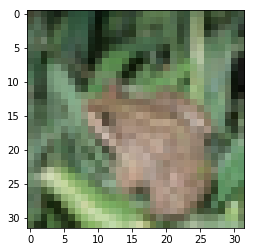

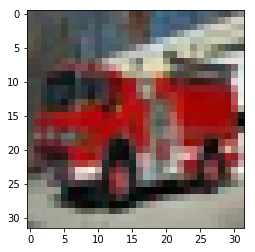

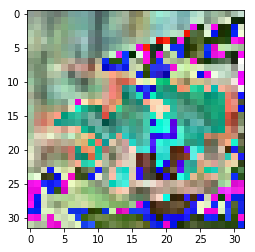


[[ 0.     0.     0.     0.     0.     0.    72.302  0.     0.     0.   ]]
<NDArray 1x10 @cpu(0)>

[[ 0.     0.     0.     9.749  0.     0.    58.008  0.     0.     3.841]]
<NDArray 1x10 @cpu(0)>


In [19]:
img1, img2 = data[0][4], data[0][23]
merged_data = img1 + img2

plt.figure()
plt.imshow(img1.transpose((1,2,0)).asnumpy())
plt.show()

plt.figure()
plt.imshow(img2.transpose((1,2,0)).asnumpy())
plt.show()

plt.figure()
plt.imshow(merged_data.transpose((1,2,0)).asnumpy())
plt.show()


print(model_edl(nd.expand_dims(img1, axis=0)))
print(model_edl(nd.expand_dims(merged_data, axis=0)))